In [1]:
import os
import numpy as np
import scipy.sparse as sp
import networkx as nx
from networkx import adjacency_matrix
import scanpy as sc
import pandas as pd
from sklearn.neighbors import kneighbors_graph as knn_g
from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import umap.umap_ as umap
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.optim import Adam

import sys
sys.path.append('/data02/tguo/space_batch_effect')
from pytorch_revgrad import RevGrad
from AGC_DA_Layers import *
from utils import *
from GraphSAGE_pytorch.layers import MeanAggregator, LSTMAggregator, MaxPoolAggregator, MeanPoolAggregator,PoolAggregator


# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# cuda=torch.cuda.is_available()
# device=np.arange(torch.cuda.device_count())
# if cuda:
#     torch.cuda.set_device(device)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [ ]:
def load_data(feat_file,edge_file,SEP,N_WALKS,WALK_LEN,N_WALK_LEN,NUM_NEG,dist_aware=True,hvg_file=None):
    feat=pd.read_csv(feat_file[0],header=0,index_col=0,sep=SEP)
    edge=pd.read_csv(edge_file[0],header=0,index_col=0).values
#     edge=np.loadtxt(edge_file[0],dtype=str)
    if len(edge.shape)<2:
        edge=np.array([[i.split(":")[0],i.split(":")[1]] for i in edge])
    if len(feat_file)>1:
        for k in np.arange(1,len(feat_file)):
            a=pd.read_csv(feat_file[k],header=0,index_col=0,sep=SEP)
            if hvg_file is not None:
                a=a.loc[:,np.loadtxt(hvg_file,dtype=str)]
            feat=pd.concat((feat,a),axis=0)
            a=np.loadtxt(edge_file[k],dtype=str)
            if len(a.shape)<2:
                a=np.array([[i.split(":")[0],i.split(":")[1]] for i in a])
            edge=np.vstack((edge,a))
    node_mapping=[{j:i for(i,j) in enumerate(feat.index)}]
    node_mapping=node_mapping[0]
    edge=np.array([[node_mapping[i[0]],node_mapping[i[1]]] for i in edge])
    adj=process_adj(edge,feat.shape[0])
   
    G=nx.Graph([(i[0],i[1]) for i in edge])
    dist=dict(nx.all_pairs_shortest_path_length(G))
    nodes=list(dist.keys())
    dataset=TensorDataset(torch.Tensor(list(nodes)).int())
    return dataset,feat,adj,dist
dirs="/data02/tguo/space_batch_effect/mouse_OB/"
samples=["BGI","SlideV2"]
SEP=','
net_cate='_KNN_'
knn=['8','8']

N_WALKS=8
WALK_LEN=1
N_WALK_LEN=8
NUM_NEG=8

feat_file=[]
edge_file=[]
meta_file=[]
flags=''
for i in range(len(samples)):
    feat_file.append(dirs+"gtt_input/"+str(samples[i])+"_mat.csv")
    edge_file.append(dirs+"gtt_input/"+str(samples[i])+"_edge"+net_cate+knn[i]+".csv")
    meta_file.append(dirs+"gtt_input/"+str(samples[i])+"_meta.csv")
    flags=flags+'_'+samples[i]
hvg_file=None
dataset,feat,adj,dist=load_data(feat_file,edge_file,SEP,N_WALKS,WALK_LEN,N_WALK_LEN,NUM_NEG)
x=minmax_scale(feat.values,axis=1)
feat=pd.DataFrame(x,index=feat.index,columns=feat.columns)


meta=pd.read_csv(meta_file[0],header=0,index_col=0)
for i in np.arange(1,len(meta_file)):
    meta=pd.concat((meta,pd.read_csv(meta_file[i],header=0,index_col=0)),axis=0)
meta=meta.values
ub=np.unique(meta[:,1])
Y=np.array([0 if i==ub[0] else 1 for i in meta[:,1]])


# feat_test=pd.read_csv(dirs+"gtt_input/10X_mat.csv",header=0,index_col=0,sep=SEP)
# edge_test=np.loadtxt(dirs+"gtt_input/10X_edge"+net_cate+"6.csv",dtype=str)
# edge_test=np.loadtxt(dirs+"gtt_input/10X_edge"+net_cate+"6_expression.csv",dtype=str)
# if len(edge_test.shape)<2:
#     edge_test=np.array([[i.split(":")[0],i.split(":")[1]] for i in edge])
    
# node_mapping_test=[{j:i for(i,j) in enumerate(feat_test.index)}]
# node_mapping_test=node_mapping_test[0]
# edge_test=np.array([[node_mapping_test[i[0]],node_mapping_test[i[1]]] for i in edge_test])
# adj_test=process_adj(edge_test,feat_test.shape[0])

# G_test=nx.Graph([(i[0],i[1]) for i in edge_test])
# dist_test=dict(nx.all_pairs_shortest_path_length(G_test))
# nodes_test=list(dist_test.keys())
# dataset_test=TensorDataset(torch.Tensor(list(nodes_test)).int())
# x=minmax_scale(feat_test.values,axis=1)
# feat_test=pd.DataFrame(x,index=feat_test.index,columns=feat_test.columns)
# meta_test=pd.read_csv(dirs+"gtt_input/10X_meta.csv",header=0,index_col=0)
# meta_test=meta_test.values
# ub_test=np.unique(meta_test[:,1])
# Y_test=np.array([0 if i==ub_test[0] else 1 for i in meta_test[:,1]])

In [ ]:
feat_test=pd.read_csv(dirs+"gtt_input/BGI_bin14_mat.csv",header=0,index_col=0,sep=SEP)
edge_test=pd.read_csv(dirs+"gtt_input/BGI_bin14_edge"+net_cate+"8.csv",header=0,index_col=0).values
if len(edge_test.shape)<2:
    edge_test=np.array([[i.split(":")[0],i.split(":")[1]] for i in edge_test])
    
node_mapping_test=[{j:i for(i,j) in enumerate(feat_test.index)}]
node_mapping_test=node_mapping_test[0]
edge_test=np.array([[node_mapping_test[i[0]],node_mapping_test[i[1]]] for i in edge_test])
adj_test=process_adj(edge_test,feat_test.shape[0])

G_test=nx.Graph([(i[0],i[1]) for i in edge_test])
dist_test=dict(nx.all_pairs_shortest_path_length(G_test))
nodes_test=list(dist_test.keys())
dataset_test=TensorDataset(torch.Tensor(list(nodes_test)).int())
x=minmax_scale(feat_test.values,axis=1)
feat_test=pd.DataFrame(x,index=feat_test.index,columns=feat_test.columns)
meta_test=pd.read_csv(dirs+"gtt_input/BGI_bin14_meta.csv",header=0,index_col=0)
meta_test=meta_test.values
ub_test=np.unique(meta_test[:,1])
Y_test=np.array([0 if i==ub_test[0] else 1 for i in meta_test[:,1]])

In [4]:
feat_test=pd.read_csv(dirs+"gtt_input/10X_mat.csv",header=0,index_col=0,sep=SEP)
edge_test=np.loadtxt(dirs+"gtt_input/10X_edge"+net_cate+"6.csv",dtype=str)
edge_test=np.loadtxt(dirs+"gtt_input/10X_edge"+net_cate+"6_expression.csv",dtype=str)
if len(edge_test.shape)<2:
    edge_test=np.array([[i.split(":")[0],i.split(":")[1]] for i in edge])
    
node_mapping_test=[{j:i for(i,j) in enumerate(feat_test.index)}]
node_mapping_test=node_mapping_test[0]
edge_test=np.array([[node_mapping_test[i[0]],node_mapping_test[i[1]]] for i in edge_test])
adj_test=process_adj(edge_test,feat_test.shape[0])

G_test=nx.Graph([(i[0],i[1]) for i in edge_test])
dist_test=dict(nx.all_pairs_shortest_path_length(G_test))
nodes_test=list(dist_test.keys())
dataset_test=TensorDataset(torch.Tensor(list(nodes_test)).int())
x=minmax_scale(feat_test.values,axis=1)
feat_test=pd.DataFrame(x,index=feat_test.index,columns=feat_test.columns)
meta_test=pd.read_csv(dirs+"gtt_input/10X_meta.csv",header=0,index_col=0)
meta_test=meta_test.values
ub_test=np.unique(meta_test[:,1])
Y_test=np.array([0 if i==ub_test[0] else 1 for i in meta_test[:,1]])

In [5]:
feat_test=pd.read_csv(dirs+"gtt_input/scRNA_mat.csv",header=0,index_col=0,sep=SEP)
edge_test=np.loadtxt(dirs+"gtt_input/scRNA_edge"+net_cate+"10_expression.csv",dtype=str)
if len(edge_test.shape)<2:
    edge_test=np.array([[i.split(":")[0],i.split(":")[1]] for i in edge])
    
node_mapping_test=[{j:i for(i,j) in enumerate(feat_test.index)}]
node_mapping_test=node_mapping_test[0]
edge_test=np.array([[node_mapping_test[i[0]],node_mapping_test[i[1]]] for i in edge_test])
adj_test=process_adj(edge_test,feat_test.shape[0])

G_test=nx.Graph([(i[0],i[1]) for i in edge_test])
dist_test=dict(nx.all_pairs_shortest_path_length(G_test))
nodes_test=list(dist_test.keys())
dataset_test=TensorDataset(torch.Tensor(list(nodes_test)).int())
x=minmax_scale(feat_test.values,axis=1)
feat_test=pd.DataFrame(x,index=feat_test.index,columns=feat_test.columns)
meta_test=pd.read_csv(dirs+"gtt_input/scRNA_meta.csv",header=0,index_col=0)
meta_test=meta_test.values
ub_test=np.unique(meta_test[:,1])
Y_test=np.array([0 if i==ub_test[0] else 1 for i in meta_test[:,1]])

In [3]:
# dirs="/data02/tguo/space_batch_effect/mouse_brain/"
# samples=["posterior1","posterior2"]
# # samples=["pa_anterior1","pa_posterior1"]
# SEP=','
# net_cate='_KNN_'
# knn=6

# N_WALKS=knn
# WALK_LEN=1
# N_WALK_LEN=knn
# NUM_NEG=6


# feat_file=[]
# edge_file=[]
# meta_file=[]
# flags=''
# for i in range(len(samples)):
#     feat_file.append(dirs+"gtt_input/"+str(samples[i])+"_mat.csv")
#     edge_file.append(dirs+"gtt_input/"+str(samples[i])+"_edge"+net_cate+str(knn)+".csv")
#     meta_file.append(dirs+"gtt_input/"+str(samples[i])+"_meta.csv")
#     flags=flags+'_'+samples[i]

# hvg_file=None
# dataset,feat,adj,dist=load_data(feat_file,edge_file,SEP,N_WALKS,WALK_LEN,N_WALK_LEN,NUM_NEG,dist_aware=False)
# x=minmax_scale(feat.values,axis=1)
# feat=pd.DataFrame(x,index=feat.index,columns=feat.columns)

# meta=pd.read_csv(meta_file[0],header=0,index_col=0)
# for i in np.arange(1,len(meta_file)):
#     meta=pd.concat((meta,pd.read_csv(meta_file[i],header=0,index_col=0)),axis=0)
# meta=meta.values
# ub=np.unique(meta[:,1])
# ub=np.unique(meta[:,1])
# Y=np.array([0 if i==ub[0] else 1 for i in meta[:,1]])

In [2]:
# dirs="/data02/tguo/space_batch_effect/PDAC/"
# samples=["PDAC-A-ST1","PDAC-B-ST1"]

# SEP=','
# net_cate='_KNN_'
# knn=8

# N_WALKS=knn
# WALK_LEN=1
# N_WALK_LEN=knn
# NUM_NEG=8


# feat_file=[]
# edge_file=[]
# flags=''
# for i in range(len(samples)):
#     feat_file.append(dirs+"gtt_input/"+str(samples[i])+"_mat.csv")
#     edge_file.append(dirs+"gtt_input/"+str(samples[i])+"_edge"+net_cate+str(knn)+".csv")
#     flags=flags+'_'+samples[i]

# hvg_file=None
# dataset,feat,adj,dist=load_data(feat_file,edge_file,SEP,N_WALKS,WALK_LEN,N_WALK_LEN,NUM_NEG,dist_aware=False)
# x=minmax_scale(feat.values,axis=1)
# feat=pd.DataFrame(x,index=feat.index,columns=feat.columns)


# cells=feat.index
# cells=np.array([i.split('-')[0]+'-'+i.split('-')[1]+'-'+i.split('-')[2] for i in cells])
# ub=np.unique(cells)
# Y=np.array([0 if i==ub[0] else 1 for i in cells])

In [2]:
dirs="/data02/tguo/space_batch_effect/breast_cancer/"
samples=["10X-1","10X-2"]

SEP=','
net_cate='_KNN_'
knn=6

N_WALKS=knn
WALK_LEN=1
N_WALK_LEN=knn
NUM_NEG=6


feat_file=[]
edge_file=[]
flags=''
for i in range(len(samples)):
    feat_file.append(dirs+"gtt_input/"+str(samples[i])+"_mat.csv")
    edge_file.append(dirs+"gtt_input/"+str(samples[i])+"_edge"+net_cate+str(knn)+".csv")
    flags=flags+'_'+samples[i]

hvg_file=None
dataset,feat,adj,dist=load_data(feat_file,edge_file,SEP,N_WALKS,WALK_LEN,N_WALK_LEN,NUM_NEG,dist_aware=False)
x=minmax_scale(feat.values,axis=1)
feat=pd.DataFrame(x,index=feat.index,columns=feat.columns)


cells=feat.index
cells=np.array([i.split('-')[0] for i in cells])
ub=np.unique(cells)
Y=np.array([0 if i==ub[0] else 1 for i in cells])

In [43]:
# import pandas as pd
# import numpy as np
# from utils import *
# dirs="/data02/tguo/space_batch_effect/simulate/"
# batch_sim="_1"
# types="_types3"
# B=2
# SEP=','
# net_cate='_KNN_'

# knn=10
# N_WALKS=knn
# WALK_LEN=1
# N_WALK_LEN=knn
# NUM_NEG=10

# feat_file=[]
# edge_file=[]
# meta_file=[]
# for i in range(B):
#     feat_file.append(dirs+"gtt_input/feat"+str(i+1)+batch_sim+types+".csv")
#     edge_file.append(dirs+"gtt_input/edge"+str(i+1)+net_cate+str(knn)+batch_sim+types+".csv")
#     meta_file.append(dirs+"gtt_input/meta"+str(i+1)+batch_sim+types+".csv")


# hvg_file=None
# dataset,feat,adj,dist=load_data(feat_file,edge_file,SEP,N_WALKS,WALK_LEN,N_WALK_LEN,NUM_NEG)
# x=minmax_scale(feat.values,axis=1)
# feat=pd.DataFrame(x,index=feat.index,columns=feat.columns)

# meta=pd.read_csv(meta_file[0],header=0,index_col=0)
# for i in np.arange(1,len(meta_file)):
#     meta=pd.concat((meta,pd.read_csv(meta_file[i],header=0,index_col=0)),axis=0)
# meta=meta.values
# ub=np.unique(meta[:,1])
# ub=np.unique(meta[:,1])
# Y=np.array([0 if i==ub[0] else 1 for i in meta[:,1]])

# flags=batch_sim+types

In [2]:
# dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
# sample_name=[151507,151508,151509,151510,151669,151670,151671,151672,151673,151674,151675,151676]
# samples=["151670","151671"]
# SEP=','
# net_cate='_Radius_'
# rad=150

# N_WALKS=6
# WALK_LEN=1
# N_WALK_LEN=6
# NUM_NEG=6

# feat_file=[]
# edge_file=[]
# meta_file=[]
# flags=''
# flags1=samples[0]
# for i in range(1,len(samples)):
#     flags1=flags1+'-'+samples[i]
# for i in range(len(samples)):
#     feat_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_features.txt")
#     edge_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_edge_Radius_"+str(rad)+".csv")
#     meta_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_label.txt")
#     flags=flags+'_'+samples[i]
# hvg_file=None
# dataset,pos_pairs,neg_pairs,feat,adj,dist=load_data(feat_file,edge_file,SEP,N_WALKS,WALK_LEN,N_WALK_LEN,NUM_NEG)
# x=minmax_scale(feat.values,axis=1)
# feat=pd.DataFrame(x,index=feat.index,columns=feat.columns)
# # import numpy_indexed as npi
# # aset = set([tuple(x) for x in pos_pairs])
# # bset = set([tuple(x) for x in neg_pairs])
# # ii=np.array([x for x in aset & bset])
# # if(ii.shape[0]>0):
# #     pos_pairs=npi.difference(pos_pairs, ii)
# #     neg_pairs=npi.difference(neg_pairs, ii)
# # np.intersect1d(np.where(pos_pairs[:,0]<4221)[0],np.where(pos_pairs[:,1]>=4221)[0])

# meta=pd.read_csv(meta_file[0],header=0,index_col=0)
# for i in np.arange(1,len(meta_file)):
#     meta=pd.concat((meta,pd.read_csv(meta_file[i],header=0,index_col=0)),axis=0)
# meta=meta.values
# ub=np.unique(meta[:,1])
# ub=np.unique(meta[:,1])
# Y=np.array([0 if i==ub[0] else 1 for i in meta[:,1]])

Done walks for 0 nodes
Done walks for 1000 nodes
Done walks for 2000 nodes
Done walks for 3000 nodes
Done walks for 4000 nodes
Done walks for 5000 nodes
Done walks for 6000 nodes
Done walks for 7000 nodes


In [ ]:
# dirs="/data02/tguo/space_batch_effect/Colon/"
# samples=["2111","2112"]
# SEP=','
# net_cate='_KNN_'
# knn=6

# N_WALKS=knn
# WALK_LEN=1
# N_WALK_LEN=knn-1
# NUM_NEG=8


# feat_file=[]
# edge_file=[]
# meta_file=[]
# flags=''
# for i in range(len(samples)):
#     feat_file.append(dirs+"gtt_input/"+str(samples[i])+"_mat.csv")
#     edge_file.append(dirs+"gtt_input/"+str(samples[i])+"_edge"+net_cate+str(knn)+".csv")
#     meta_file.append(dirs+"gtt_input/"+str(samples[i])+"_meta.csv")
#     flags=flags+'_'+samples[i]

# hvg_file=None
# dataset,pos_pairs,neg_pairs,feat,adj,dist=load_data(feat_file,edge_file,SEP,N_WALKS,WALK_LEN,N_WALK_LEN,NUM_NEG,dist_aware=False)
# x=minmax_scale(feat.values,axis=1)
# feat=pd.DataFrame(x,index=feat.index,columns=feat.columns)

# meta=pd.read_csv(meta_file[0],header=0,index_col=0)
# for i in np.arange(1,len(meta_file)):
#     meta=pd.concat((meta,pd.read_csv(meta_file[i],header=0,index_col=0)),axis=0)
# meta=meta.values
# ub=np.unique(meta[:,1])
# ub=np.unique(meta[:,1])
# Y=np.array([0 if i==ub[0] else 1 for i in meta[:,1]])

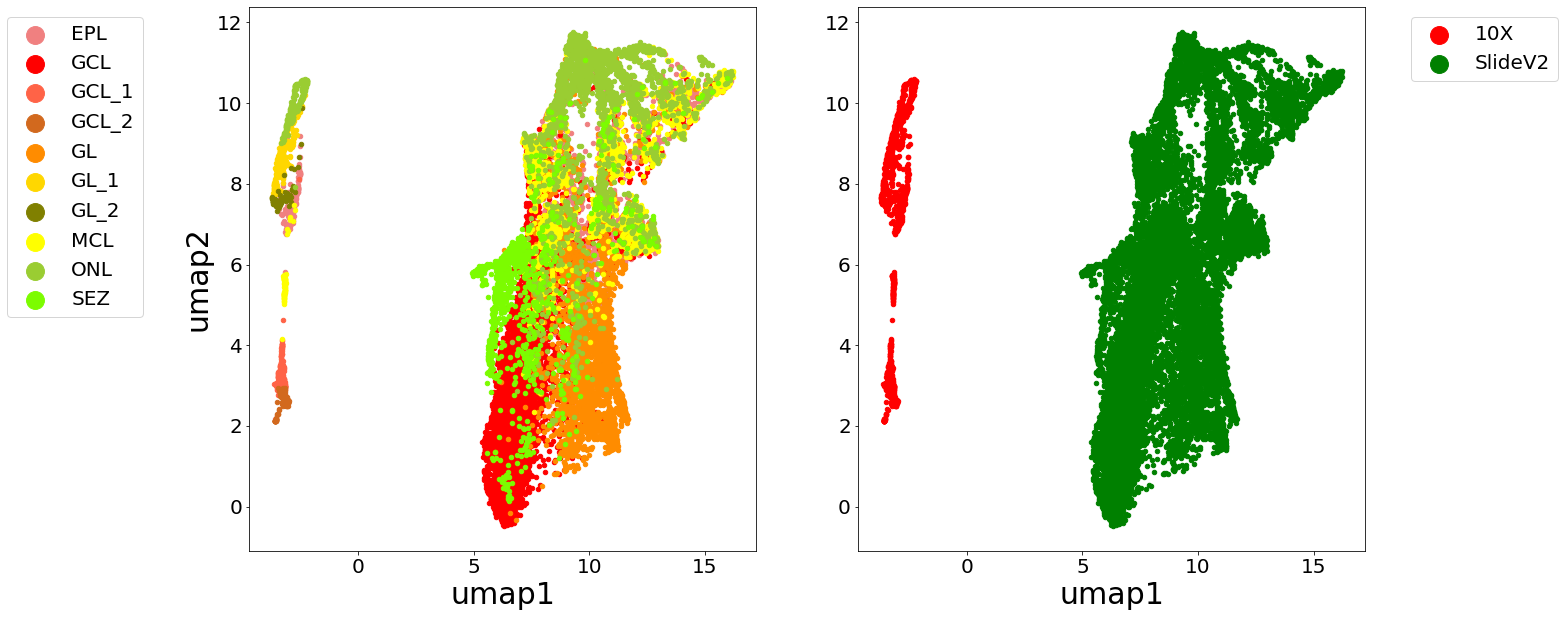

In [21]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
celltype=meta[:,0]
batch=meta[:,1]
ul=np.unique(celltype)
ub=np.unique(batch)
x=PCA(n_components=30).fit_transform(feat.values)
umap_mat=umap.UMAP().fit_transform(x)
colour2=['r','g','black','cyan','blue','purple','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=20
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

In [6]:
class A_G_Combination(nn.Module):
    def __init__(self, AEdims, AEdimsR,GSdims,agg_class,num_samples,zdim,beta):
        super(A_G_Combination, self).__init__()
        AEzdim=AEdims[-1]
        GSzdim=GSdims[-1]
        self.ae=AE(AEdims, AEdimsR)
        self.gs=GraphSAGE(AEdims[0],GSdims,agg_class,num_samples=num_samples)
        self.beta=beta
#         self.combine_layer=nn.Linear(AEzdim+GSzdim,zdim)
    def forward(self,x,node_layers, mappings,rows,de_act):
        x1=x[[mappings[0][i] for i in node_layers[-1]],:]
        _,ae_z=self.ae.en(x1)
        gs_z=self.gs(x,node_layers, mappings,rows)
#         z=self.combine_layer(torch.cat((ae_z,gs_z),dim=1))
        z=(1-self.beta)*ae_z+self.beta*gs_z
        _,x_bar=self.ae.de(z,de_act)
        final_z=[ae_z,gs_z,z]
        return final_z,x_bar,x1
    
class A_G_Combination_DA_complex(nn.Module):
    def __init__(self, AEdims, AEdimsR,GSdims,agg_class,num_samples,zdim,znoise_dim,beta,CLdims,DIdims):
        super(A_G_Combination_DA_complex, self).__init__()
        self.znoise_dim=znoise_dim
        self.agc=A_G_Combination(AEdims, AEdimsR,GSdims,agg_class,num_samples,zdim,beta)
        self.clas=Classifier(CLdims)
        self.disc=Discriminator(DIdims)
    def forward(self,x,node_layers, mappings,rows,lamda,de_act,cl_act):
        self.revgrad=RevGrad(lamda)
        final_z,x_bar,x1=self.agc(x,node_layers, mappings,rows,de_act)
        ae_z,gs_z,z=final_z
        znoise=z[:,:self.znoise_dim]
        zbio=z[:,self.znoise_dim:]
        clas_out=self.clas(znoise,act=cl_act)
        disc_out=self.disc(self.revgrad(zbio),act=cl_act)
        ae_out=[x_bar,x1]
        return final_z,ae_out,clas_out,disc_out

In [7]:
###网络结构参数###
zdim=32
x_dim=feat.shape[1]
h_dim=[512]
h_dimR=list(reversed(h_dim))
AEdims=[x_dim,h_dim,zdim]
AEdimsR=[zdim,h_dimR,x_dim]
GSdims=[512,zdim]
znoise_dim=4
CLdims=[znoise_dim,[],1]
DIdims=[zdim-znoise_dim,[32,16],1]
###网络选择####
num_samples=20
agg_class=[MeanAggregator,PoolAggregator,MaxPoolAggregator,MeanPoolAggregator,LSTMAggregator]
agg_class=agg_class[0]
de_act=nn.Sigmoid()
cl_act=nn.Sigmoid()
###训练参数####
BS=256
epochs=100
lr=1e-3
weight_decay=5e-4
alpha1=x_dim
alpha2=1.0
alpha3=1.0
alpha4=1.0
lamda=1.0
beta=1.0
Q=10
MARGIN=3
len_dataloader=feat.shape[0]//BS

model=A_G_Combination_DA_complex(AEdims, AEdimsR,GSdims,agg_class,num_samples,zdim,znoise_dim,beta,CLdims,DIdims).cuda()
# # # model=torch.nn.DataParallel(model).cuda()
optimizer=Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
data_loader=DataLoader(dataset=dataset, batch_size=BS,shuffle=True,num_workers=8,drop_last=True)
unsupervised_loss=UnsupervisedLoss(adj.tolil().rows, dist, Q,N_WALKS,WALK_LEN,N_WALK_LEN,NUM_NEG,MARGIN)


model.train()
print('--------------------------------')
print('Training.')
for epoch in np.arange(0,epochs):
    print('Epoch {} / {}'.format(epoch+1, epochs))
    total_loss=0.0;AE_loss=0.0;GS_loss=0.0;CLAS_loss=0;DISC_loss=0
    t=time.time()
    for (batch_idx, target_idx) in enumerate(data_loader):
        target_idx=target_idx[0]
        all_idx=np.asarray(list(unsupervised_loss.extend_nodes(target_idx.tolist())))
        all_layer,all_mapping=layer_map(all_idx.tolist(),adj,len(GSdims))
        all_rows=adj.tolil().rows[all_layer[0]]
        all_feature=torch.Tensor(feat.iloc[all_layer[0],:].values).float().cuda()
        all_embed,ae_out,clas_out,disc_out=model(all_feature,all_layer,all_mapping,all_rows,lamda,de_act,cl_act)
        [ae_embed,gs_embed,embed]=all_embed
        [x_bar,x]=ae_out
        true_batch=torch.Tensor(Y[all_layer[-1]]).cuda()
        gs_loss = unsupervised_loss.get_loss_xent(embed, all_idx)
        ae_loss=nn.BCELoss()(x_bar,x)
        clas_loss=nn.BCELoss()(clas_out,true_batch.reshape(-1,1))
        disc_loss=nn.BCELoss()(disc_out,true_batch.reshape(-1,1))
        loss=ae_loss*alpha1+gs_loss*alpha2+clas_loss*alpha3+disc_loss*alpha4
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        AE_loss+=ae_loss.item()
        GS_loss+=gs_loss.item()
        CLAS_loss+=clas_loss.item()
        DISC_loss+=disc_loss.item()
#     total_loss=loss.item()
#     AE_loss=ae_loss.item()
#     GS_loss=gs_loss.item()
#     CLAS_loss=clas_loss.item()
#     DISC_loss=disc_loss.item()
    aa=(batch_idx+1)
    print('time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss=','%.5f/%.5f/%.5f/%.5f/%.5f/%.5f'%((time.time()-t),total_loss/aa,AE_loss/aa,GS_loss/aa,
                                                                                       CLAS_loss/aa,DISC_loss/aa))
print('Finished training.')
print('--------------------------------')
torch.save(model.state_dict(),dirs+"model/AGC_DA_complex"+flags+"_xent.pt")

--------------------------------
Training.
Epoch 1 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 140.16734/1370.46781/0.31900/1.84756/0.69505/0.69274
Epoch 2 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 159.97806/651.23676/0.15133/1.27699/0.68868/0.66847
Epoch 3 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 155.33436/619.88468/0.14406/1.10350/0.68662/0.66504
Epoch 4 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 131.46279/612.39020/0.14232/1.07100/0.68561/0.65692
Epoch 5 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 131.96241/609.40232/0.14163/1.06239/0.68425/0.65012
Epoch 6 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 133.48303/606.38685/0.14093/1.03968/0.68215/0.64370
Epoch 7 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 132.99720/604.90700/0.14059/1.02620/0.68052/0.63913
Epoch 8 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 139.57694/603.15389/0.14018/1.01852/0.67745/0.63903
Epoc

time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 131.62350/588.44712/0.13687/1.00469/0.14134/0.65775
Epoch 70 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 132.37043/588.57757/0.13690/1.01362/0.14673/0.65620
Epoch 71 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 132.93390/588.40699/0.13686/1.01528/0.15226/0.65524
Epoch 72 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 132.03298/588.19806/0.13682/1.01136/0.13570/0.65378
Epoch 73 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 132.36169/588.27766/0.13684/1.00716/0.13496/0.65552
Epoch 74 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 131.89410/588.15313/0.13681/1.00785/0.13261/0.65540
Epoch 75 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 131.88082/587.91969/0.13675/1.01221/0.13875/0.65307
Epoch 76 / 100
time/total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 132.11797/587.80521/0.13673/1.01065/0.13463/0.65522
Epoch 77 / 100
time/total_loss/AE_loss/GS_loss/clas_los

In [ ]:
# model.load_state_dict(torch.load(dirs+"model/AGC_DA_complex"+flags+"_xent.pt"))
model.eval()
all_idx=np.arange(feat.shape[0])
all_layer,all_mapping=layer_map(all_idx.tolist(),adj,len(GSdims))
all_rows=adj.tolil().rows[all_layer[0]]
all_feature=torch.Tensor(feat.iloc[all_layer[0],:].values).float().cuda()
all_embed,ae_out,clas_out,disc_out=model(all_feature,all_layer,all_mapping,all_rows,lamda,de_act,cl_act)
[ae_embed,gs_embed,embed]=all_embed
[x_bar,x]=ae_out
embed=embed.cpu().detach()
names=['GTT_'+str(i) for i in range(embed.shape[1])]
embed1=pd.DataFrame(np.array(embed),index=feat.index,columns=names)
embed1.to_csv(dirs+"gtt_output/AGC_embed"+flags+"_xent.csv")
x_bar1=pd.DataFrame(np.array(x_bar.cpu().detach()),index=feat.index,columns=feat.columns)
x_bar1.to_csv(dirs+"gtt_output/AGC_exp"+flags+"_xent.csv")
embed_new=torch.cat((torch.zeros((embed.shape[0],znoise_dim)),embed[:,znoise_dim:]),dim=1)
xbar_new=np.array(model.agc.ae.de(embed_new.cuda(),de_act)[1].cpu().detach())
xbar_new1=pd.DataFrame(xbar_new,index=feat.index,columns=feat.columns)
xbar_new1.to_csv(dirs+"gtt_output/AGC_exp_corrected0"+flags+"_xent.csv")

/home/tguo/tguo2/miniconda3/envs/stnet/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


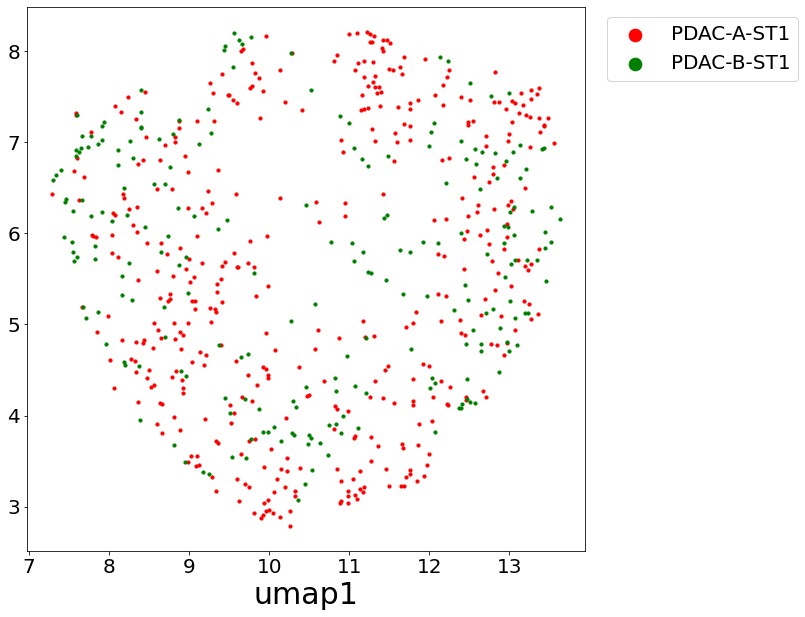

In [15]:
batch=cells
import umap.umap_ as umap
import matplotlib.pyplot as plt
# x=PCA(n_components=30).fit_transform(x_bar.cpu().detach())
umap_mat=umap.UMAP().fit_transform(embed[:,znoise_dim:])
# umap_mat1=pd.DataFrame(umap_mat,index=feat.index,columns=['umap1','umap2'])
# umap_mat1.to_csv(dirs+"gtt_output/AGC_umap"+flags+"_xent.csv")
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,1,figsize=(10,10))
size=10
for i in range(len(ub)):
    axs.scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)
axs.set_xlabel("umap1",fontsize=30)
axs.legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs.tick_params(axis='both', which='major', labelsize=20)

In [12]:
# all_idx_test=np.arange(feat_test.shape[0])
# all_layer_test,all_mapping_test=layer_map(all_idx_test.tolist(),adj_test,len(GSdims))
# all_rows_test=adj_test.tolil().rows[all_layer_test[0]]
# all_feature_test=torch.Tensor(feat_test.iloc[all_layer_test[0],:].values).float().cuda()
# all_embed_test,ae_out_test,clas_out_test,disc_out_test=model(all_feature_test,all_layer_test,all_mapping_test,all_rows_test,lamda,de_act,cl_act)
# [ae_embed_test,gs_embed_test,embed_test]=all_embed_test
# [x_bar_test,x_test]=ae_out_test
# embed_test=embed_test.cpu().detach()
# embed_1=np.vstack((embed_test,embed))
# cells=np.hstack((feat_test.index,feat.index))
# embed_new=torch.cat((torch.zeros((embed_1.shape[0],znoise_dim)),torch.Tensor(embed_1[:,znoise_dim:])),dim=1)
# xbar_new=np.array(model.agc.ae.de(embed_new.cuda(),de_act)[1].cpu().detach())
# xbar_new1=pd.DataFrame(xbar_new,index=cells,columns=feat.columns)

# names=['GTT_'+str(i) for i in range(embed.shape[1])]
# embed1=pd.DataFrame(np.array(embed),index=cells,columns=names)
# embed1.to_csv(dirs+"gtt_output/AGC_embed"+flags+'_10X'+"_xent.csv")
#  xbar_new1.to_csv(dirs+"gtt_output/AGC_exp_corrected0"+flags+'_10X'+"_expression_xent.csv")

# names=['GTT_'+str(i) for i in range(embed.shape[1])]
# embed1=pd.DataFrame(np.array(embed_1),index=cells,columns=names)
# embed1.to_csv(dirs+"gtt_output/AGC_embed"+flags+'_scRNA'+"_expression_xent.csv")
# xbar_new1.to_csv(dirs+"gtt_output/AGC_exp_corrected0"+flags+'_scRNA'+"_expression_xent.csv")


# celltype_test=np.array(meta_test[:,0],dtype=str)
# celltype_test=celltype_test[list(all_mapping_test[-1].keys())]
# batch_test=np.array(meta_test[:,1],dtype=str)
# batch_test=batch_test[list(all_mapping_test[-1].keys())]
# ul_test=np.unique(celltype_test)
# ub_test=np.unique(batch_test)
# meta_1=np.vstack((meta_test,meta))
# celltype=np.array(meta_1[:,0],dtype=str)
# batch=np.array(meta_1[:,1],dtype=str)
# ul=np.unique(celltype)
# ub=np.unique(batch)

In [13]:
# celltype=np.array(meta[:,0],dtype=str)
# celltype=celltype[list(all_mapping[-1].keys())]
# batch=np.array(meta[:,1],dtype=str)
# batch=batch[list(all_mapping[-1].keys())]
# ul=np.unique(celltype)
# ub=np.unique(batch)



In [10]:
# ub=['SlideV2','10X']
# ub=['SlideV2','BGI']
ub=['SlideV2','BGI','10X']
celltype[celltype=='SEZ']='GCL'
celltype[celltype=='Meninges']='ONL'
celltype[celltype=='OPL']='EPL'
# ul=np.unique(celltype)
# ul=['ONL','GL','EPL','MCL','GCL']

In [17]:
ub=['scRNA','BGI','SlideV2']

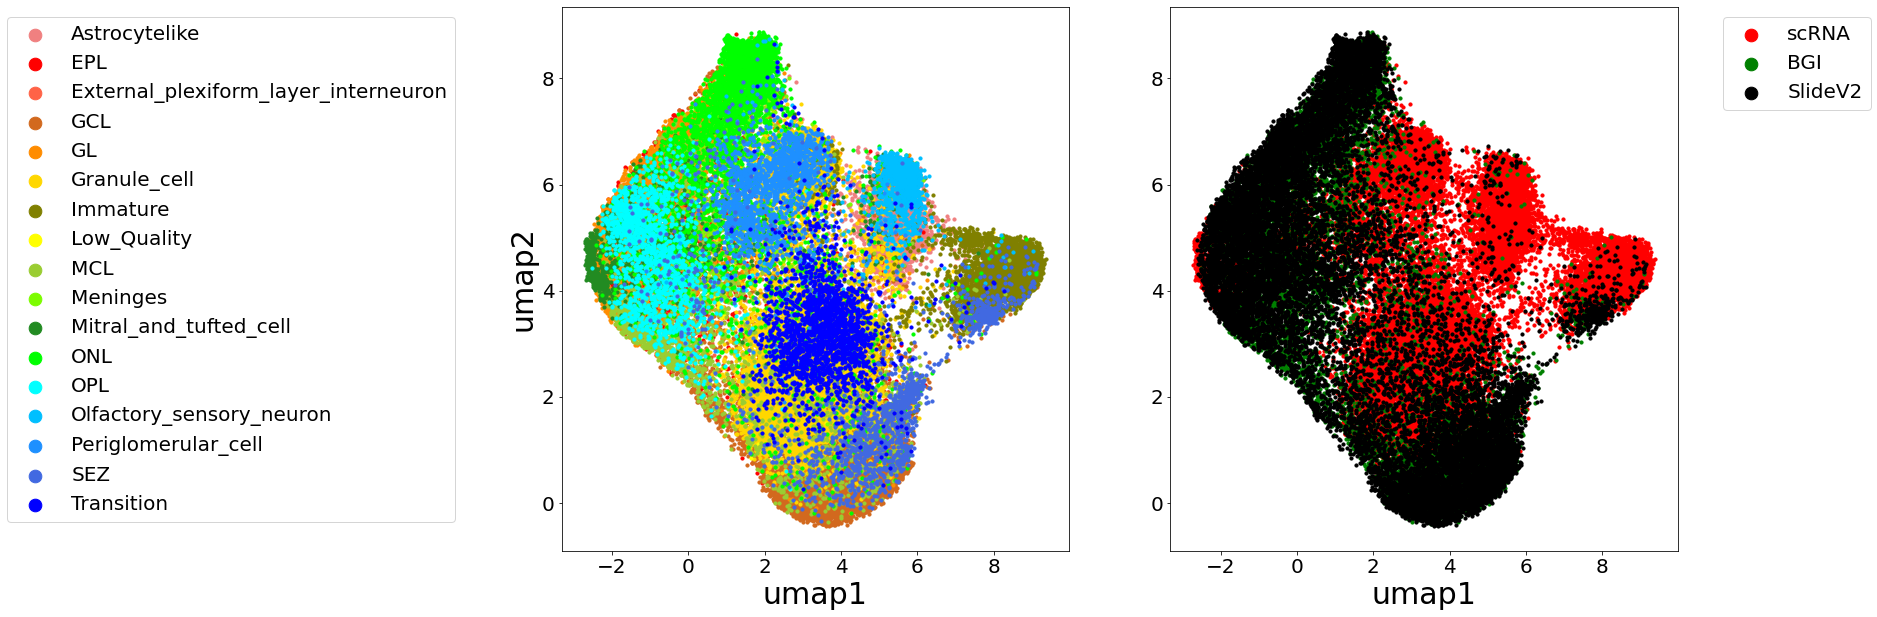

In [18]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
# x=PCA(n_components=30).fit_transform(x_bar.cpu().detach())
# umap_mat=umap.UMAP().fit_transform(embed_1[:,znoise_dim:])
# umap_mat1=pd.DataFrame(umap_mat,index=feat.index,columns=['umap1','umap2'])
# umap_mat1.to_csv(dirs+"gtt_output/AGC_umap"+flags+"_xent.csv")
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=10
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

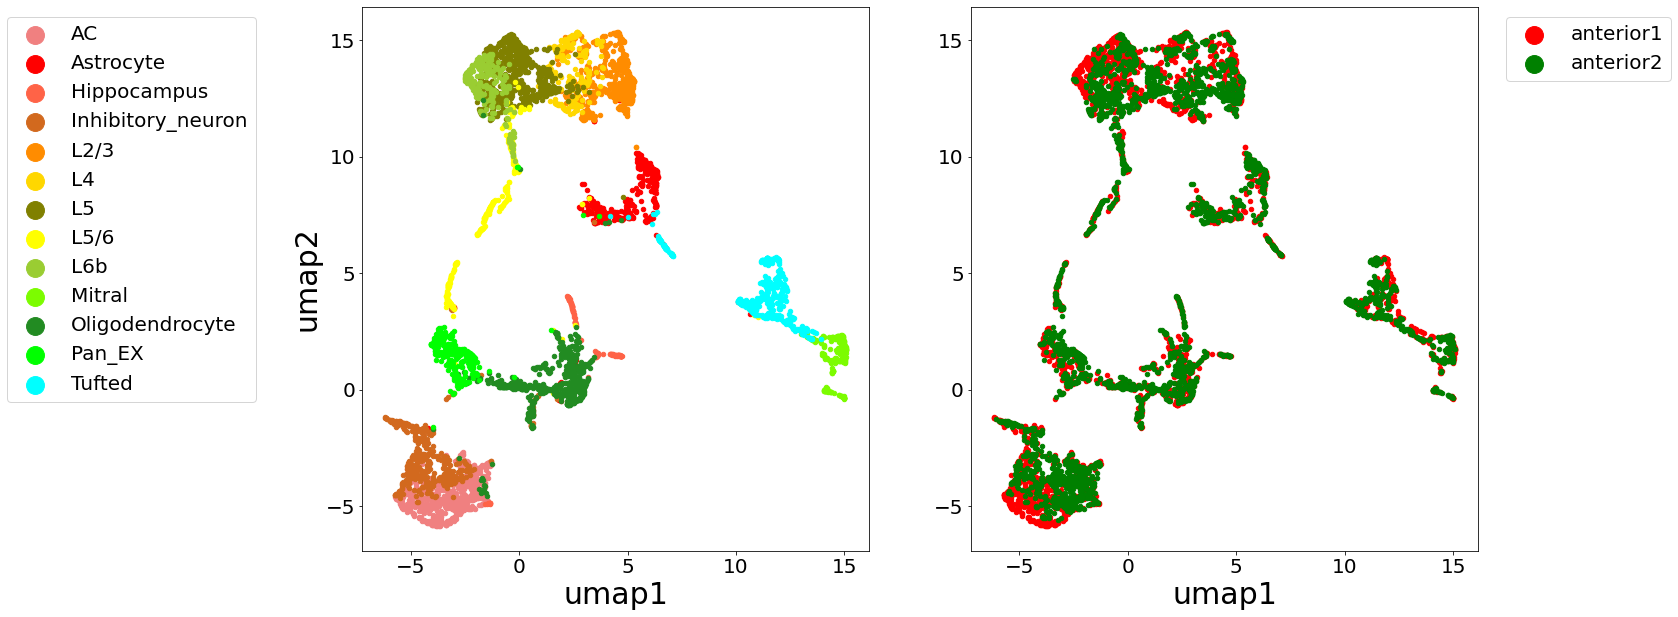

In [14]:
flags='_151507_151509'
dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
sample_name=[151507,151508,151509,151510,151669,151670,151671,151672,151673,151674,151675,151676]
embed1=pd.read_csv(dirs+"gtt_output/AGC_embed"+flags+"_xent.csv",header=0,index_col=0)
embed2=pd.read_csv(dirs+"methods/seurat_mat"+flags+".txt",header=0,index_col=0)
embed3=pd.read_csv(dirs+"methods/harmony_mat"+flags+".txt",header=0,index_col=0)

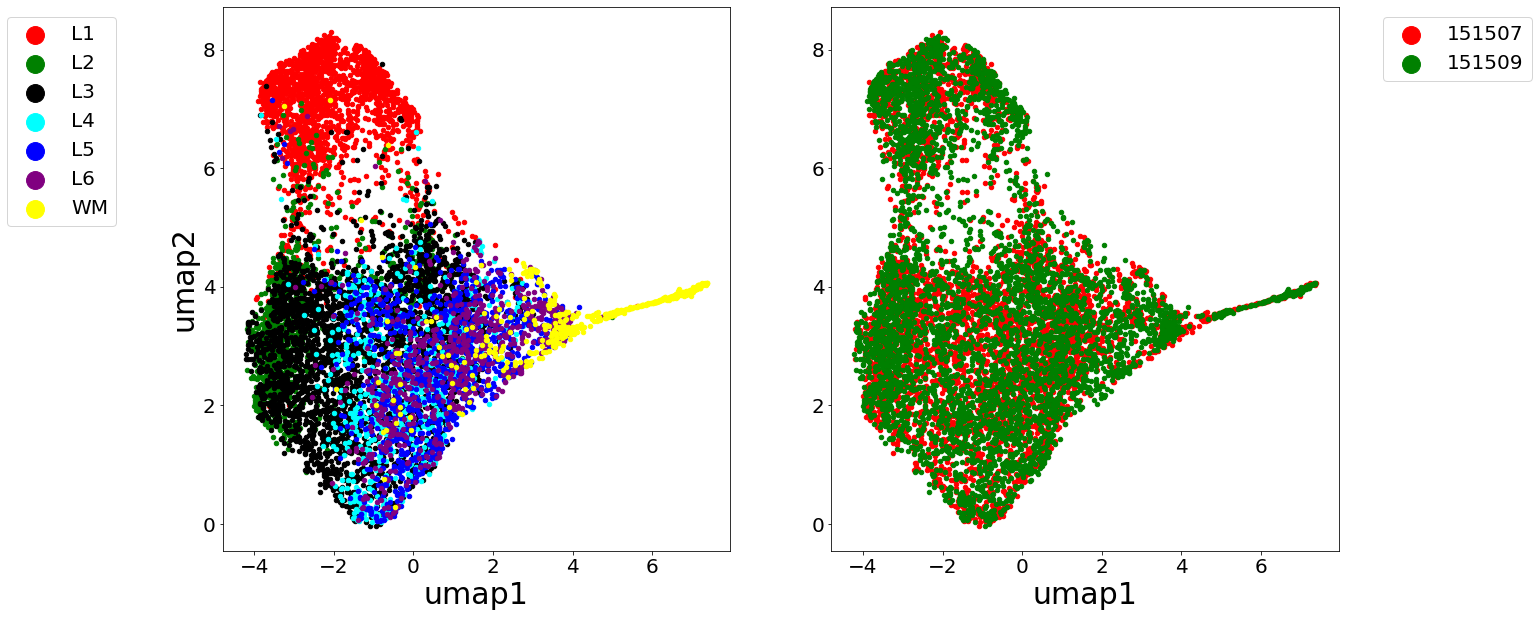

In [15]:
umap_mat=umap.UMAP().fit_transform(embed2)
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=20
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour2[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)